# Importar módulos

In [1]:
import pandas as pd
import csv
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Funciones

In [4]:
#funcion para determinar el D80 de un set de datos de análisis granulométrico
def D80(set_datos, peso_procesado):
    # lectura de datos
    fuente = pd.read_csv(f'../data/Grinding_data/{set_datos}')
    data = pd.DataFrame({'Mesh': fuente.loc[:,'Mesh'], 'Particle size': fuente.loc[:,'Particle size'], 
                         'Peso': fuente.loc[:,'Peso']}) 
    Pesos_cada_malla_temp = list(data.loc[:, 'Peso'])
    # Calcular la cantidad de lamas que se perdieron
    data_add = {'Mesh':'-400', 'Particle size':15, 'Peso': peso_procesado - sum(Pesos_cada_malla_temp) }
    # Añadir dicha cantidad al data frame
    data.loc[-1]=data_add
    # Extraer datos útiles del data frame
    Particle_size = list(data.loc[:, 'Particle size'])
    Pesos_cada_malla = list(data.loc[:, 'Peso'])
    Alim_recalculada = sum(Pesos_cada_malla)
    # Calcular el retenido en cada malla
    Retenido_malla = [i / Alim_recalculada for i in Pesos_cada_malla]
    # Calcular el retenido acumulado
    Retenido_Acumulado = [Retenido_malla[0]]
    for i in range(len(Retenido_malla) - 1):
        Retenido_Acumulado.append(Retenido_Acumulado[i] + Retenido_malla[i + 1])
    # Calcular el pasado acumulado tomando en cuenta que se trata del complemento del retenido acumulado
    Pasado_acumulado = [1 - i for i in Retenido_Acumulado]
    # Determinar una curva que permita la interpolación lineal entre dos puntos
    Curva_interpolation = interp1d(sorted(Pasado_acumulado), sorted(Particle_size) )
    # Determinar el d80 mediante una inteprolación lineal
    d80 = Curva_interpolation(0.8)
    ## Añadir las lineas de retenido, retenido acumulado y pasado acumulado al dataframe ##
    data['Retenido'] = Retenido_malla
    data['Retenido Acumulado'] = Retenido_Acumulado
    data['Pasado Acumulado'] = Pasado_acumulado
    return d80, data

# Manejo de datos

In [10]:
# Procesamiento de los datos obtenidos experimentalmente tanto para obtener el d80 como la tabla resultante
[d80_p4_0, datos_p4_0] = D80('P4/Datos_dp_P4.csv', 2000)
[d80_p4_25, datos_p4_25] = D80('P4/molienda_p4_25min.csv', 500)
[d80_p4_50, datos_p4_50] = D80('P4/molienda_p4_50min.csv', 500)
[d80_p4_75, datos_p4_75] = D80('P4/molienda_p4_75min.csv', 500)
[d80_p4_105, datos_p4_105] = D80('P4/molienda_p4_105min.csv', 500)
resultados = list([datos_p4_0, datos_p4_25, datos_p4_50, datos_p4_75, datos_p4_105])
tiempos = ['0min', '25min', '50min', '75min', '105min'] # tiempos de molienda
ruta = '../data/Resultados/D80s_P4.xlsx'
writer = pd.ExcelWriter(ruta)
for i,j in zip(resultados, tiempos):
    i.to_excel(writer, sheet_name=j, index=False)
writer.close()

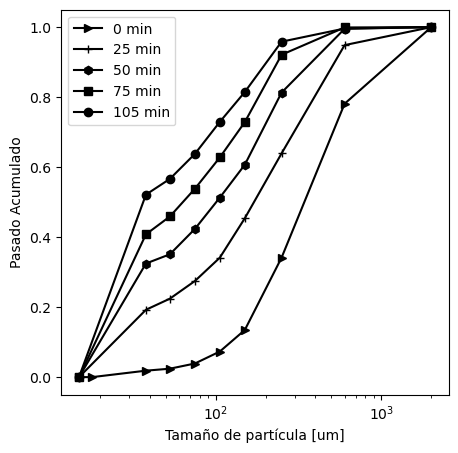

In [13]:
# Graficar d80s P4
tiempos = [0, 25, 50, 75, 105] # tiempos de molienda
fig = plt.figure(figsize=[5, 5], num=1)
ax = plt.axes()
ax.semilogx(datos_p4_0['Particle size'], datos_p4_0['Pasado Acumulado'], '>-k', label='0 min')
ax.semilogx(datos_p4_25['Particle size'], datos_p4_25['Pasado Acumulado'], '+-k', label='25 min')
ax.semilogx(datos_p4_50['Particle size'], datos_p4_50['Pasado Acumulado'], 'h-k', label='50 min')
ax.semilogx(datos_p4_75['Particle size'], datos_p4_75['Pasado Acumulado'], 's-k', label='75 min')
ax.semilogx(datos_p4_105['Particle size'], datos_p4_105['Pasado Acumulado'], 'o-k', label='105 min')
ax.legend()
ax.set_xlabel('Tamaño de partícula [um]')
ax.set_ylabel('Pasado Acumulado')
#extract information
#plt.savefig('Figuras/D80s_molienda_P4.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()


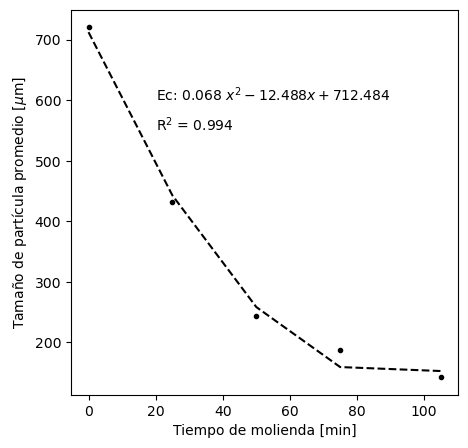

In [15]:
# Curva de molienda
d80s = [d80_p4_0, d80_p4_25, d80_p4_50, d80_p4_75, d80_p4_105]
fig = plt.figure(figsize=[5, 5], num=2)
ax = plt.axes()
ax.plot(tiempos, d80s, '.k', label='Datos experimentales')
# Linea de tendencia de segundo orden
coeficientes = np.polyfit(tiempos, d80s, 2) 
f = np.poly1d(coeficientes)
ax.plot(tiempos, f(tiempos), '--k')
plt.rcParams.setdefault('font.family')
ax.set_xlabel('Tiempo de molienda [min]')
ax.set_ylabel(r'Tamaño de partícula promedio [$\mu$m]')
plt.text(20,600, r'Ec: {:.3f} $x^2  {:.3f} x + {:.3f}$'.format(coeficientes[0], 
                                                            coeficientes[1], 
                                                            coeficientes[2]))
plt.text(20,550, r'R$^2$ = {:.3f}'.format(r2_score(d80s, f(tiempos))))
#export picture
#plt.savefig('../Figuras/Curva_molienda_P4.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

# Muestra P6

In [17]:
# Procesamiento de los datos obtenidos experimentalmente tanto para obtener el d80 como la tabla resultante
[d80_p6_0, datos_p6_0] = D80('P6/Datos_Curva_molienda_p6_0min.csv', 500)
[d80_p6_15, datos_p6_15] = D80('P6/Datos_Curva_molienda_p6_15min.csv', 500)
[d80_p6_30, datos_p6_30] = D80('P6/Datos_Curva_molienda_p6_30min.csv', 500)
[d80_p6_45, datos_p6_45] = D80('P6/Datos_Curva_molienda_p6_45min.csv', 500)
[d80_p6_60, datos_p6_60] = D80('P6/Datos_Curva_molienda_p6_60min.csv', 500)
[d80_p6_75, datos_p6_75] = D80('P6/Datos_Curva_molienda_p6_75min.csv', 500)
[d80_p6_90, datos_p6_90] = D80('P6/Datos_Curva_molienda_p6_90min.csv', 500)
[d80_p6_105, datos_p6_105] = D80('P6/Datos_Curva_molienda_p6_105min.csv', 500)
[d80_p6_125, datos_p6_125] = D80('P6/Datos_Curva_molienda_p6_125min.csv', 500)
resultados = list([datos_p6_0, datos_p6_15, datos_p6_30, datos_p6_45, datos_p6_60, datos_p6_75, datos_p6_90, datos_p6_105, datos_p6_125])
tiempos = ['0min', '15min', '30min', '45min', '60min', '75min', '90min', '105min', '125min'] # tiempos de molienda
ruta = '../data/Resultados/D80s_P6.xlsx'
writer = pd.ExcelWriter(ruta)
for i,j in zip(resultados, tiempos):
    i.to_excel(writer, sheet_name=j, index=False)
writer.close()

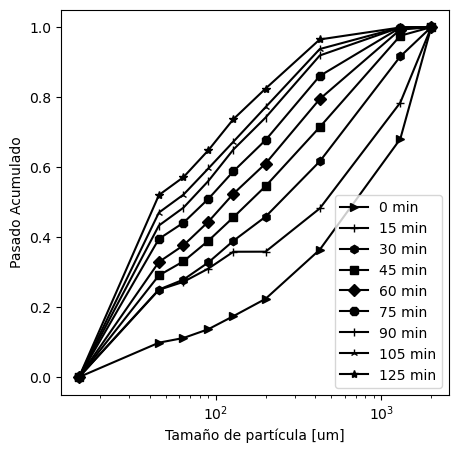

In [19]:
# Graficar d80s P6
tiempos = [0, 15, 30, 45, 60, 75, 90, 105, 125] # tiempos de molienda
fig = plt.figure(figsize=[5, 5], num=3)
ax = plt.axes()
ax.semilogx(datos_p6_0['Particle size'], datos_p6_0['Pasado Acumulado'], '>-k', label='0 min')
ax.semilogx(datos_p6_15['Particle size'], datos_p6_15['Pasado Acumulado'], '+-k', label='15 min')
ax.semilogx(datos_p6_30['Particle size'], datos_p6_30['Pasado Acumulado'], 'h-k', label='30 min')
ax.semilogx(datos_p6_45['Particle size'], datos_p6_45['Pasado Acumulado'], 's-k', label='45 min')
ax.semilogx(datos_p6_60['Particle size'], datos_p6_60['Pasado Acumulado'], 'D-k', label='60 min')
ax.semilogx(datos_p6_75['Particle size'], datos_p6_75['Pasado Acumulado'], '8-k', label='75 min')
ax.semilogx(datos_p6_90['Particle size'], datos_p6_90['Pasado Acumulado'], '|-k', label='90 min')
ax.semilogx(datos_p6_105['Particle size'], datos_p6_105['Pasado Acumulado'], '2-k', label='105 min')
ax.semilogx(datos_p6_125['Particle size'], datos_p6_125['Pasado Acumulado'], '*-k', label='125 min')
ax.legend()
ax.set_xlabel('Tamaño de partícula [um]')
ax.set_ylabel('Pasado Acumulado')
#export figure
#plt.savefig('Figuras/D80s_molienda_P6.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

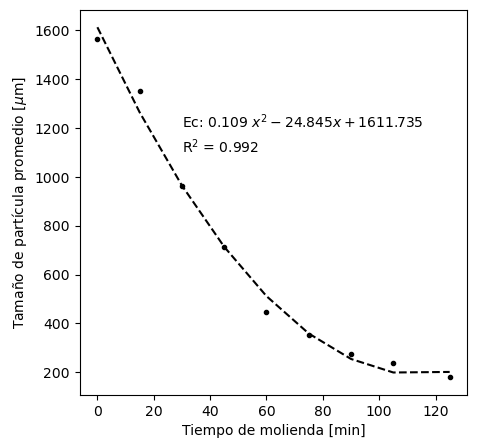

In [20]:
# Curva de molienda
d80s = [d80_p6_0, d80_p6_15, d80_p6_30, d80_p6_45, d80_p6_60, d80_p6_75, d80_p6_90, d80_p6_105, d80_p6_125]
fig = plt.figure(figsize=[5, 5], num=4)
ax = plt.axes()
ax.plot(tiempos, d80s, '.k', label='Datos experimentales')
# Linea de tendencia de segundo orden
coeficientes = np.polyfit(tiempos, d80s, 2) 
f = np.poly1d(coeficientes)
ax.plot(tiempos, f(tiempos), '--k')
plt.rcParams.setdefault('font.family')
ax.set_xlabel('Tiempo de molienda [min]')
ax.set_ylabel(r'Tamaño de partícula promedio [$\mu$m]')
plt.text(30,1200, r'Ec: {:.3f} $x^2  {:.3f} x + {:.3f}$'.format(coeficientes[0], 
                                                            coeficientes[1], 
                                                            coeficientes[2]))
plt.text(30,1100, r'R$^2$ = {:.3f}'.format(r2_score(d80s, f(tiempos))))
#export picture
#plt.savefig('Figuras/Curva_molienda_P6.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

# Muestra BP

In [23]:
### BP ####
# Procesamiento de los datos obtenidos experimentalmente tanto para obtener el d80 como la tabla resultante
[d80_BP_0, datos_BP_0] = D80('BP/Datos_Curva_Molienda_BP_0min.csv', 500)
[d80_BP_15, datos_BP_15] = D80('BP/Datos_Curva_Molienda_BP_15min.csv', 500)
[d80_BP_30, datos_BP_30] = D80('BP/Datos_Curva_Molienda_BP_30min.csv', 500)
[d80_BP_45, datos_BP_45] = D80('BP/Datos_Curva_Molienda_BP_45min.csv', 500)
[d80_BP_60, datos_BP_60] = D80('BP/Datos_Curva_Molienda_BP_60min.csv', 500)
resultados = list([datos_BP_0, datos_BP_15, datos_BP_30, datos_BP_45, datos_BP_60])
tiempos = ['0min', '15min', '30min', '45min', '60min'] # tiempos de molienda
ruta = '../data/Resultados/D80s_BP.xlsx'
writer = pd.ExcelWriter(ruta)
for i,j in zip(resultados, tiempos):
    i.to_excel(writer, sheet_name=j, index=False)
writer.close()

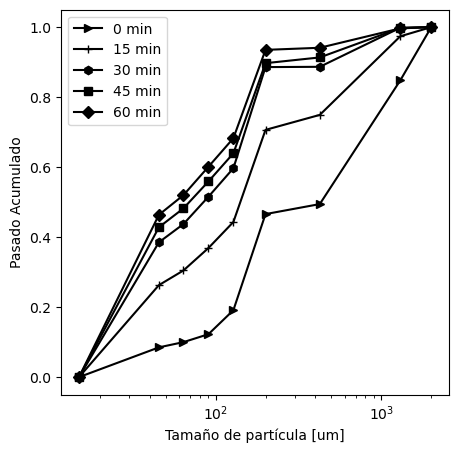

In [24]:
# Graficar d80s BP
tiempos = [0, 15, 30, 45, 60] # tiempos de molienda
fig = plt.figure(figsize=[5, 5], num=5)
ax = plt.axes()
ax.semilogx(datos_BP_0['Particle size'], datos_BP_0['Pasado Acumulado'], '>-k', label='0 min')
ax.semilogx(datos_BP_15['Particle size'], datos_BP_15['Pasado Acumulado'], '+-k', label='15 min')
ax.semilogx(datos_BP_30['Particle size'], datos_BP_30['Pasado Acumulado'], 'h-k', label='30 min')
ax.semilogx(datos_BP_45['Particle size'], datos_BP_45['Pasado Acumulado'], 's-k', label='45 min')
ax.semilogx(datos_BP_60['Particle size'], datos_BP_60['Pasado Acumulado'], 'D-k', label='60 min')
ax.legend()
ax.set_xlabel('Tamaño de partícula [um]')
ax.set_ylabel('Pasado Acumulado')
# Export pictures
#plt.savefig('Figuras/D80s_molienda_BP.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

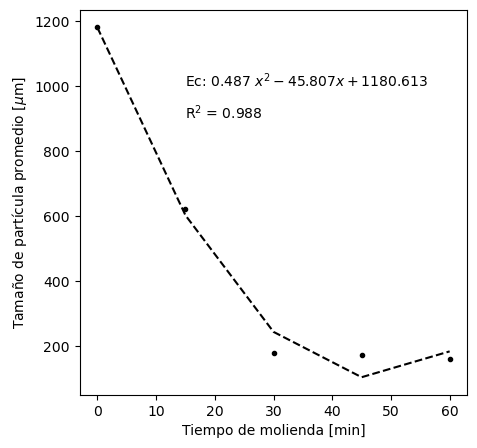

In [25]:
# Curva de molienda
d80s = [d80_BP_0, d80_BP_15, d80_BP_30, d80_BP_45, d80_BP_60]
fig = plt.figure(figsize=[5, 5], num=5)
ax = plt.axes()
ax.plot(tiempos, d80s, '.k', label='Datos experimentales')
# Linea de tendencia de segundo orden
coeficientes = np.polyfit(tiempos, d80s, 2) 
f = np.poly1d(coeficientes)
ax.plot(tiempos, f(tiempos), '--k')
plt.rcParams.setdefault('font.family')
ax.set_xlabel('Tiempo de molienda [min]')
ax.set_ylabel(r'Tamaño de partícula promedio [$\mu$m]')
plt.text(15,1000, r'Ec: {:.3f} $x^2  {:.3f} x + {:.3f}$'.format(coeficientes[0], 
                                                            coeficientes[1], 
                                                            coeficientes[2]))
plt.text(15,900, r'R$^2$ = {:.3f}'.format(r2_score(d80s, f(tiempos))))
# Export figure
# plt.savefig('Figuras/Curva_molienda_BP.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()
